# Part 2 - House prices

Data cleaning
---
Your analysis should include the necessary data cleaning steps. For instance

- Find and handle incorrect, missing values
- Correct inconsistencies in the variables
- Handle outliers

You are free to choose your preferred approach to handle each step. For instance, you might want to replace missing values with the average or the most frequent value or create an missing category. In any case, justify your choices!

You can find a detailed description of each variable in the ``documentation.txt file``, but there are a few things to know.

- The ``Order`` and ``PID`` variables are identifiers. They are not useful to predict house prices.
- The variables are not necessarily encoded consistently. For instance, ``MS SubClass`` (the type of dwelling) and ``MS Zoning`` (zoning classification) are both categorical variables, but one is encoded with numerical values and the other with short labels.
- The data isn’t clean: there are incorrect and missing values, outliers and inconsistencies

You should address all these issues during the data cleaning stage.

In [3]:
# import libraries 
%matplotlib inline
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns
import re

In [4]:
# load data train/test 
train_df = pd.read_csv("house-prices.csv")
test_df = pd.read_csv("house-prices-test.csv")

# Display the first 5 rows of data train
train_df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


In [5]:
# Show size of the dataset
train_df.shape

(2430, 82)

In [6]:
# Count how many times each data type is present in the dataset
pd.value_counts(train_df.dtypes)

object     43
int64      28
float64    11
dtype: int64

In [7]:
# Check for duplicated values
train_df.duplicated().sum()

0

The ``Order`` and ``PID`` variables are identifiers. They are not useful to predict house prices. I will drop them

In [8]:
# Drop Order and PID variable 
train_df = train_df.drop(["Order", "PID"], axis=1)

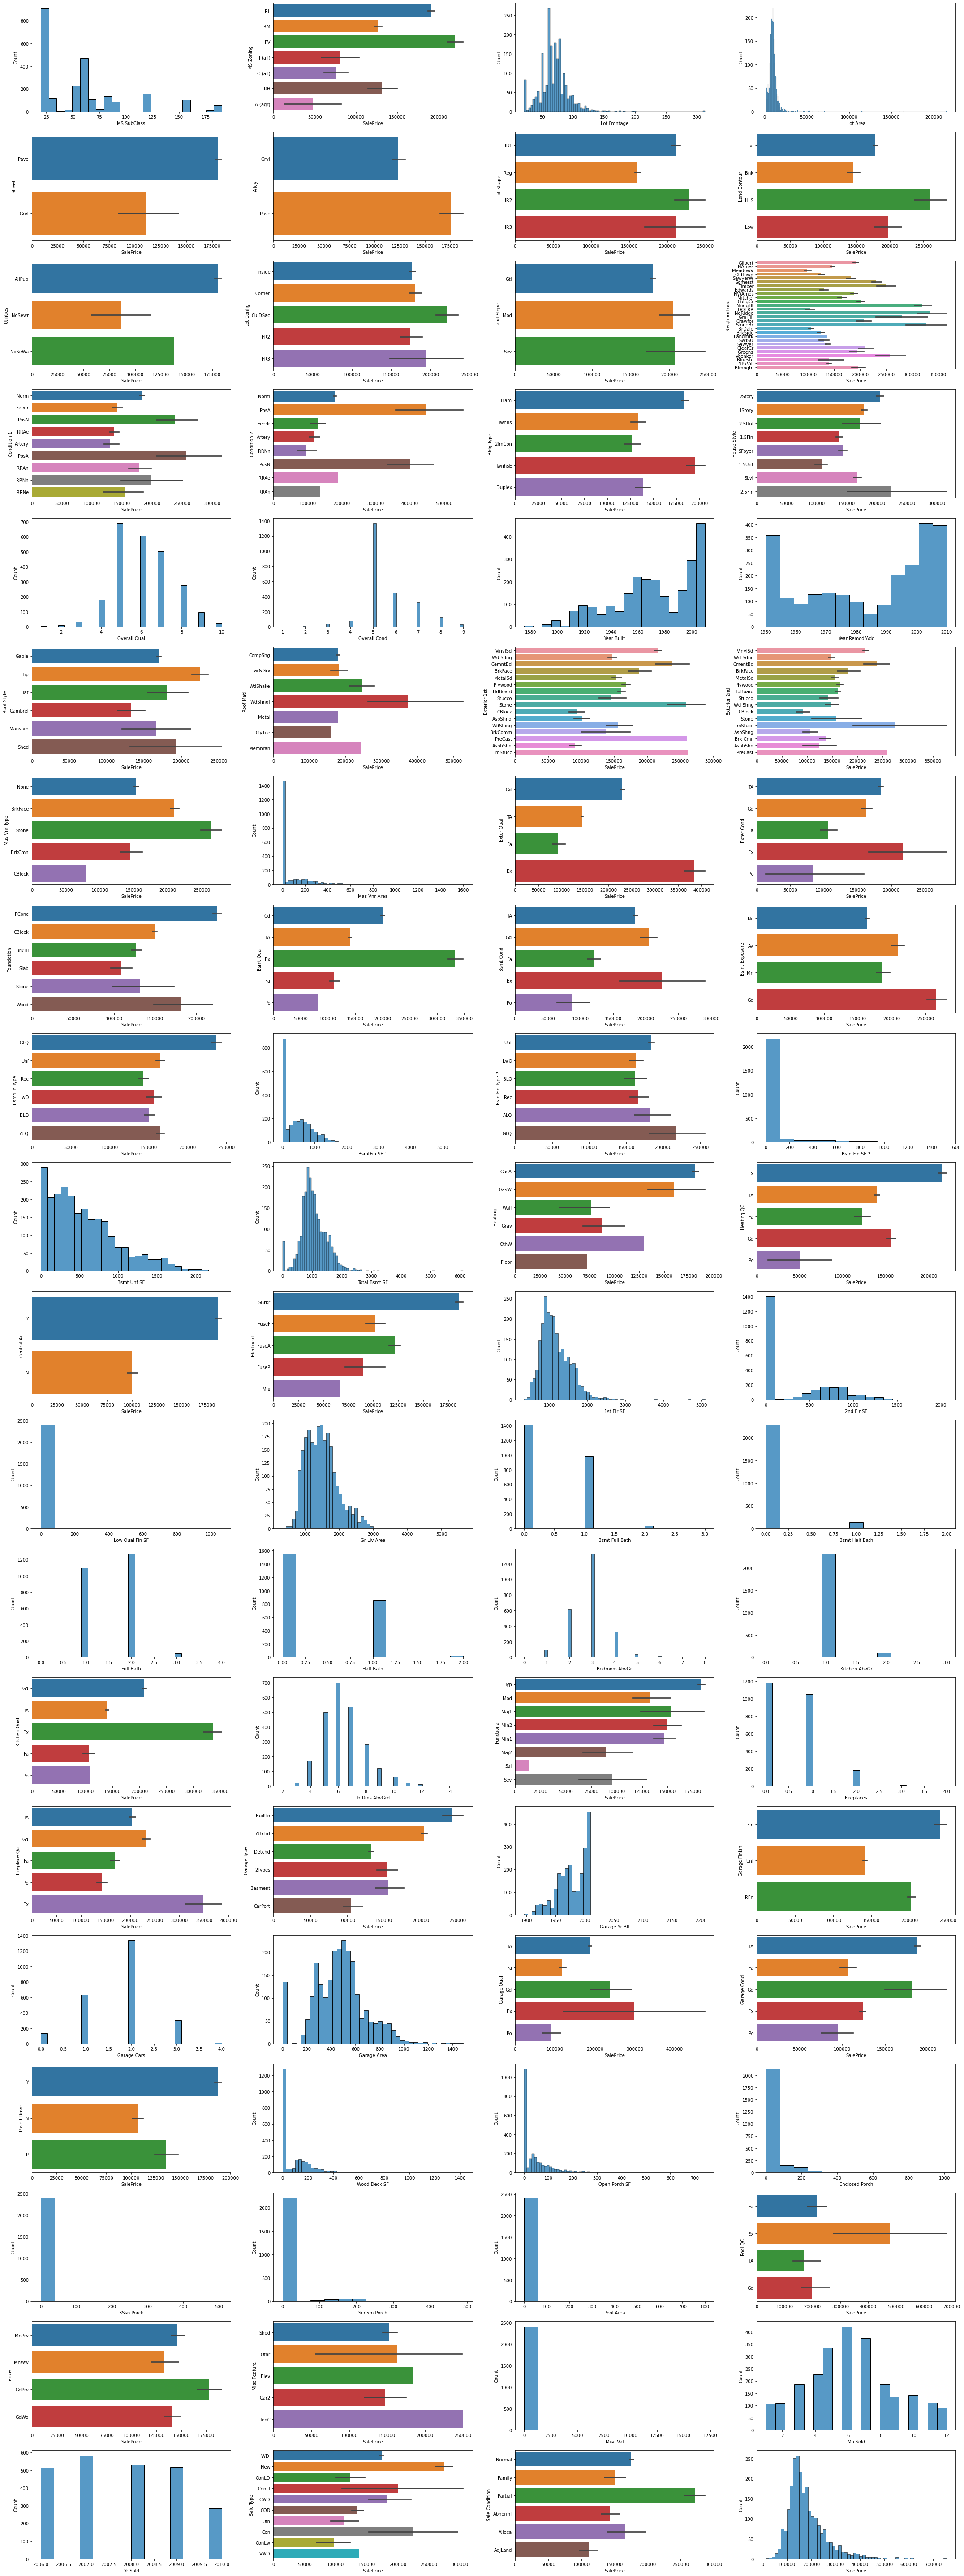

In [9]:
# Plot all the data
fig, axes = plt.subplots(round(len(train_df.columns)/4), 4, figsize=(30, 80))

for col, ax in zip(train_df.columns, axes.ravel()):
    if train_df[col].dtype in [np.int64, np.float64]:   # change degree 
        sns.histplot(data=train_df, x=col, ax=ax)
    else:
        # sns.barplot() will show the average value of the target variable for each category in the non-numerical column.
        sns.barplot(data=train_df, y=col, x="SalePrice", ax=ax)

plt.tight_layout()
plt.show()

### Investigate the percentage of missing values per feature. 

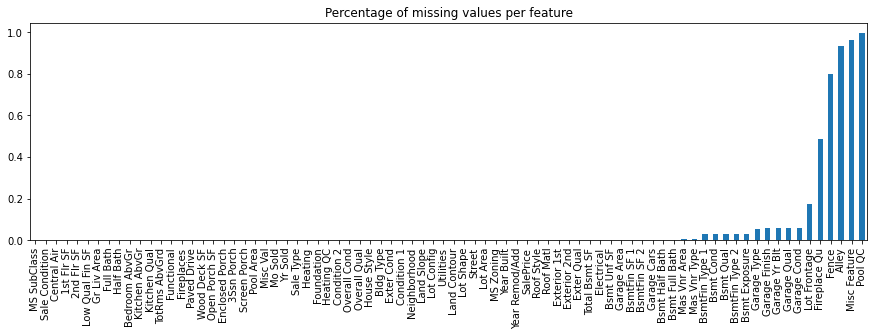

In [10]:
# Investigate the percentage of missing values per feature. 
train_df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per feature");

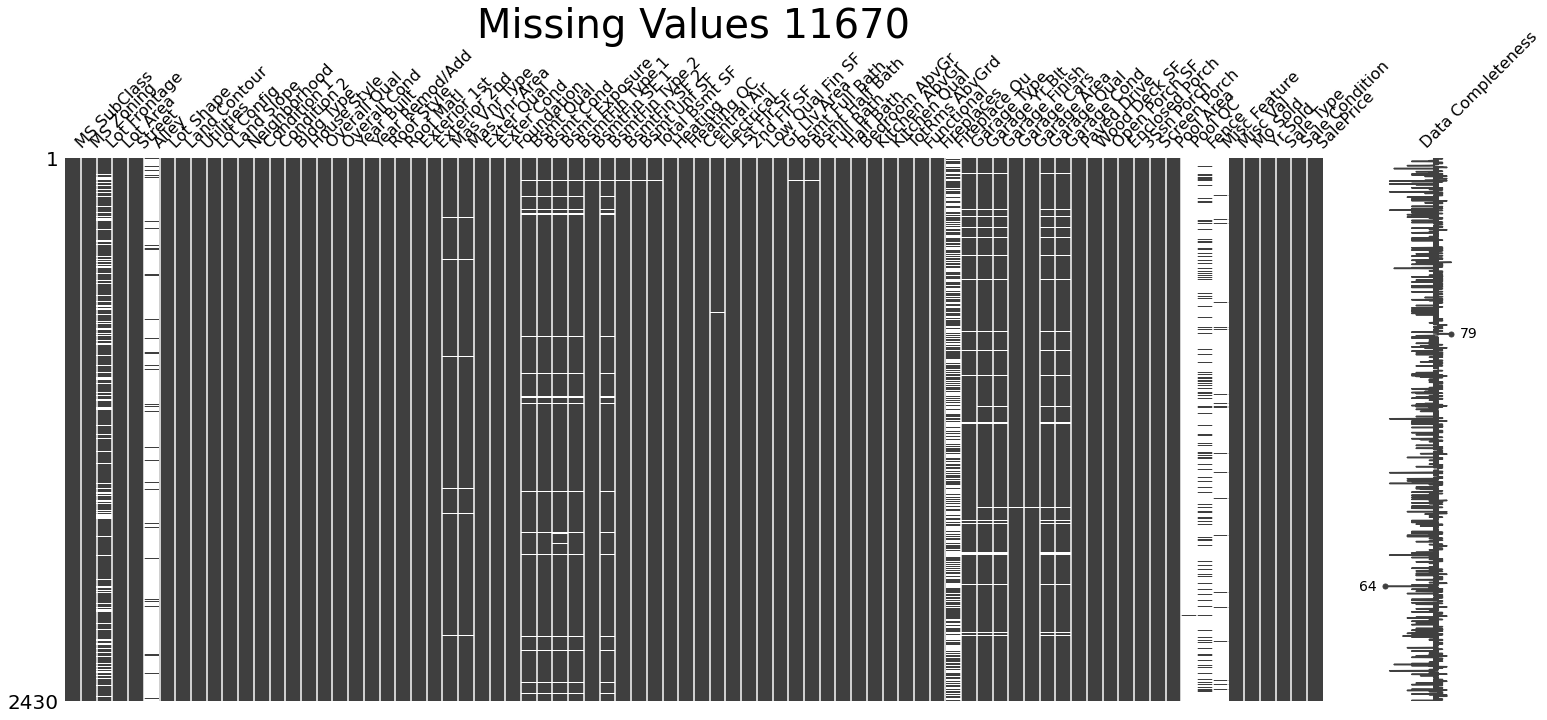

In [11]:
import missingno as msno
# Using msno.matrix() to see more details
msno.matrix(train_df, labels=True)
plt.title("Missing Values {}".format(train_df.isna().sum().sum()), fontsize=40)
plt.show()

We have 11670 missing values by checking the documentation we see 4 categories of variables nominal, ordinal, discrete and continuous. I will deal with missing values in each category separately. 

Steps:
1. Find the label that matches the variables and save them in a separate list.
2. Encode ordinal variable so I can deal with missing values and prepare the data for the modelling part.
3. I will check each category separately so I can deal with missing values by filling or dropping them.


In [12]:
# Search in the documentation the labels of each variable 

# Find the label that matches the variables 
def find_col_types(text):
    types = ["Nominal", "Ordinal", "Discrete",]
    pattern = r"(.*)\((Nominal|Ordinal|Discrete|Continuous)\):"
    matches = re.findall(pattern, text)
    # Save results in a dictionary 
    return {col.strip(): typ.strip() for col, typ in matches}

# Read txt file
with open('documentation.txt', 'r',  encoding='ISO-8859-1') as file:
    text = file.read()
    types = find_col_types(text)


In [13]:
# Save variables corresponding to the labels
col_normal = []

col_ordinal = []

col_discrete = []

col_continous = []

remove_items = {
    "Nominal": ['Exterior 1', 'Exterior 2', 'PID'],
    "Ordinal": ['HeatingQC', 'KitchenQual'],
    "Discrete": ['Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Order'],
    "Continuous": ['3-Ssn Porch']
}

col_types = {
    "Nominal": col_normal, 
    "Ordinal": col_ordinal, 
    "Discrete": col_discrete, 
    "Continuous": col_continous}


# Save labels in dictionary
for col, value in types.items():
    for type_name, columns in col_types.items():
        if value == type_name:
            columns.append(col)


# Remove column not find in the data
for type_name, columns in col_types.items():
    items_remove = remove_items.get(type_name)
    # Check if items
    if items_remove:
        for item in items_remove:
            # Check if item is in columns
            if item in columns:
                columns.remove(item)

# Adding a space to "BsmtFinType 2" and "FireplaceQu"
col_ordinal = list(map(lambda col: col.replace("BsmtFinType 2", "BsmtFin Type 2").replace("FireplaceQu", "Fireplace Qu"), col_ordinal))


for type_name, columns in col_types.items():
    print(f"{type_name} columns: {len(columns)}")

Nominal columns: 21
Ordinal columns: 20
Discrete columns: 11
Continuous columns: 18


In [14]:
len(col_normal) + len(col_ordinal) + len(col_discrete) + len(col_continous)

70

# plot to check 
https://stackoverflow.com/questions/34251641/how-to-make-a-bar-plot-of-non-numerical-data-in-pandas


# check this like below!
https://www.python-graph-gallery.com
https://www.data-to-viz.com/


try to use barh plot for non numercal values by counting them
try to plot the data to have a over view of the data


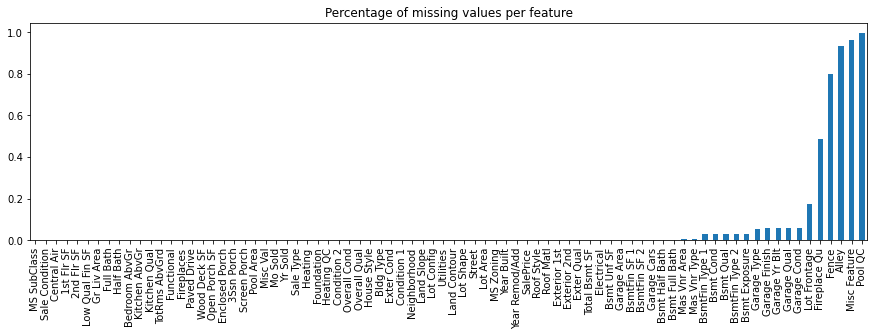

In [15]:
# Investigate the percentage of missing values per feature. 
train_df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per feature");

In [16]:
# Check a Ordinal feature
train_df["Garage Cond"].value_counts(dropna=False)

TA     2202
NaN     138
Fa       61
Po       14
Gd       13
Ex        2
Name: Garage Cond, dtype: int64

We see that ``NaN`` values as a mining in this case NaN is for Garage Cond 

Decision: 
---
First I will encode the ordinal so I can fill NaN values that could occur. 

Encoding all Ordinal variables by defining a numerical scale 1 to 5. 
This way, the machine-learning algorithm will have a sense of the relative distances between the categories, which can be useful information.

And Using One_hot encoding for norminal values. 

In [17]:
# Encoding scale 
encoding_Lot_Shape = {"Reg" : 4, "IR1" : 3, "IR2" : 2, "IR3" : 1}

encoding_Utilities =  {"AllPub" : 4, "NoSewr" : 3, "NoSeWa" : 2, "ELO" : 1}	
	
encoding_Land_Slope = {"Gtl" : 3, "Mod" : 2, "Sev" : 1}

encoding_Bsmt_Exposure = {"Gd" : 5, "Av" : 4, "Mn" : 3, "No" : 2, np.nan : 0}

# Note: BsmtFinType1 and BsmtFinType2 have the same scale
encoding_BsmtFinType1 = {
    "GLQ" :	6,
    "ALQ" :	5,
    "BLQ" : 4,
    "Rec" :	3,
    "LwQ" :	2,
    "Unf" :	1,
    np.nan : 0
}


encoding_Electrical = { 
    "SBrkr" : 5,
    "FuseA" : 4,	
    "FuseF"	: 3,
    "FuseP"	: 2,
    "Mix" : 1,
    np.nan : 0
}


encoding_Functional = {
    "Typ" : 8,
    "Min1" : 7,
    "Min2" : 6,
    "Mod" : 5,
    "Maj1" : 4,
    "Maj2" : 3,
    "Sev" : 2,
    "Sal" :	1
}

encoding_Fireplace_Qu = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1,
    np.nan : 0

}

encoding_Paved_Drive = {"Y" : 3, "P" : 2, "N" : 1}

encoding_Fence = {"GdPrv" : 5, "MnPrv" : 4, "GdWo" : 3, "MnWw" : 2,	np.nan : 0}

encoding_other = {np.nan : 0,"Po" : 1, "Fa" : 2,"TA" : 3,"Gd" : 4,"Ex" : 5}

ordinal_encoding = {
    "Lot Shape" : encoding_Lot_Shape,
    "Utilities" : encoding_Utilities,
    "Land Slope" : encoding_Land_Slope,
    "Overall Qual" : None,
    "Overall Cond" : None,
    "Bsmt Exposure" : encoding_Bsmt_Exposure,
    "BsmtFin Type 1" : encoding_BsmtFinType1,
    "BsmtFin Type 2" : encoding_BsmtFinType1,
    "Electrical" : encoding_Electrical,
    "Fireplace Qu": encoding_Fireplace_Qu,
    "Functional" : encoding_Functional,
    "Paved Drive" : encoding_Paved_Drive,
    "Fence" : encoding_Fence,
    
}


# Encoding ordinal values by numbers
for col in col_ordinal:
    col_encoding = ordinal_encoding.setdefault(col, encoding_other)
    if col_encoding == None:
        continue
    train_df[col] = train_df[col].map(col_encoding)



# Display the change 
train_df[col_ordinal].head()

,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Electrical,Functional,Fireplace Qu,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence
0,3,4,3,7,5,4,3,4,3,2,6,1,5,8,3,3,3,3,0,0
1,4,4,3,6,6,3,3,3,3,2,1,1,5,8,4,3,3,3,0,0
2,4,4,3,4,5,3,3,3,3,2,1,1,5,8,0,3,3,3,0,0
3,3,4,3,5,5,3,3,3,3,2,3,1,5,8,4,3,3,3,0,0
4,3,4,3,7,4,2,3,3,3,2,1,1,3,8,4,3,3,1,0,4


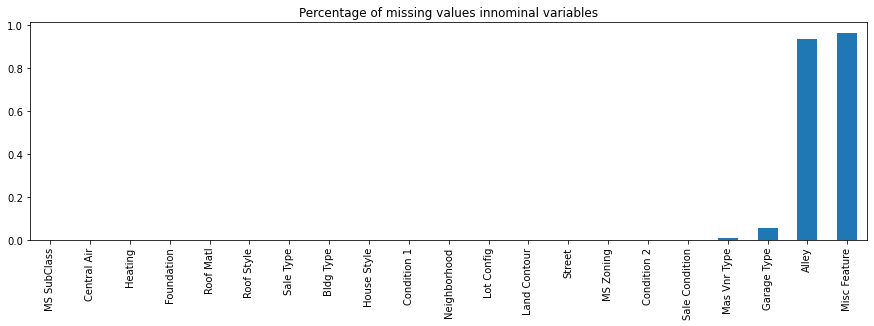

In [18]:
# Investigate the percentage of missing values for nominal variables
train_df[col_normal].isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values innominal variables");

In [19]:
# Display detail of the percentage 
col_normal_with_missing = ["Alley", "Mas Vnr Type", "Garage Type", "Misc Feature"]
train_df[col_normal_with_missing].isna().mean()

Alley           0.932922
Mas Vnr Type    0.008230
Garage Type     0.055967
Misc Feature    0.962963
dtype: float64

Columns with nominal variables NaN values will be fill  by they corresponding mining 

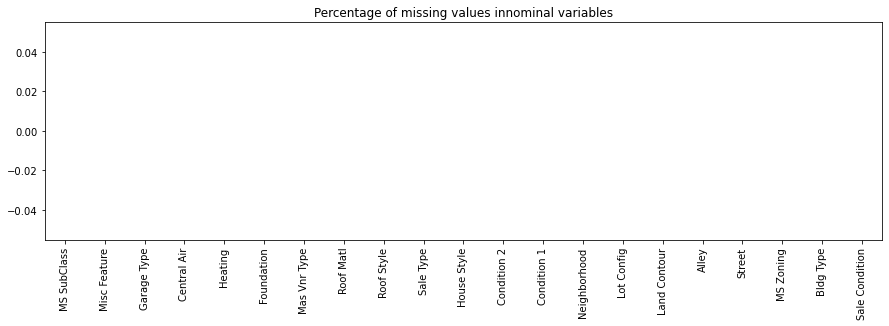

In [20]:
fill_nan = {
    "Alley": "No alley access",
    "Mas Vnr Type": "None",
    "Garage Type": "Garage Type",
    "Misc Feature" : "None"
}

# Fill NaN values by they corresponding mining 
for col in fill_nan:
    train_df[col] = train_df[col].fillna(fill_nan.get(col))

# Display change 
train_df[col_normal].isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values innominal variables");

### Investigate the percentage of missing values for nominal variables

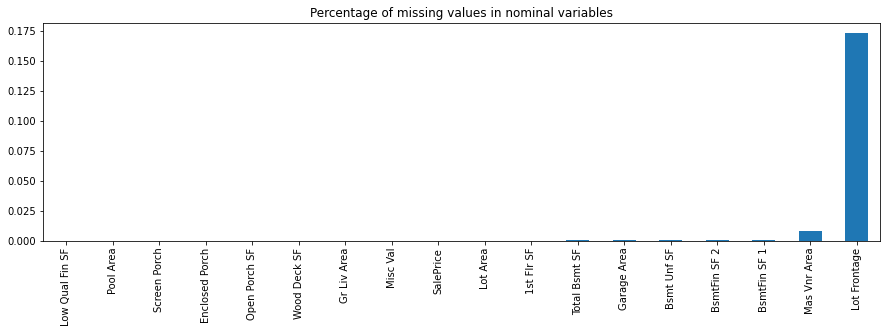

In [21]:
# Investigate the percentage of missing values for nominal variables
train_df[col_continous].isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values in nominal variables");

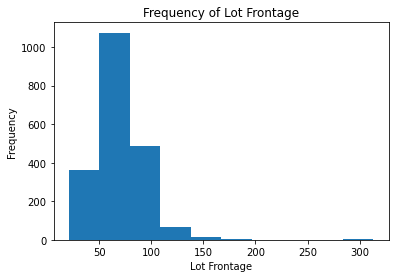

In [22]:
train_df["Lot Frontage"].plot.hist()
plt.title("Frequency of Lot Frontage")
plt.xlabel("Lot Frontage")
plt.show()

In [23]:
train_df["Lot Frontage"].median()

68.0

For ``Lot Frontage`` We see that most of the Nan values are between 60 and 75 with median at 69.  So I will fill NaN by the median values. 

For the other columns the percentage of missing values is small and to ovoid introduce bias and uncertainty I will drop NaN values.

In [24]:
# Prop NaN values
col_continous_with_missing = ["Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "Garage Area"]

# For "Lot Frontage" fill NaN by the median values
train_df["Lot Frontage"] = train_df["Lot Frontage"].fillna(train_df["Lot Frontage"].median())

# Drop other Nan values
train_df = train_df.dropna(subset=col_continous_with_missing)

# Display the change 
train_df[col_continous].isna().sum()

Lot Frontage       0
Lot Area           0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64

### Investigate the percentage of missing values for discrete variables

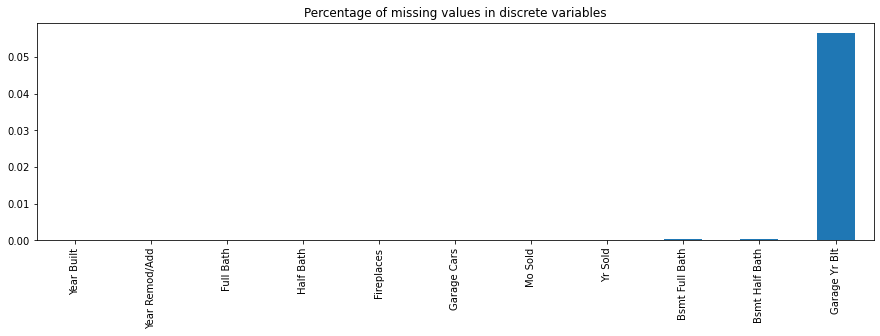

In [25]:
# Investigate the percentage of missing values for discrete variables
train_df[col_discrete].isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values in discrete variables");

We see that ``Garage Yr Blt`` has the most missing values with only 6%.   It's a small percentage of missing values so I will drop them. 

In [26]:
# Drop NaN in discrete variables
col_drop = ["Bsmt Full Bath", "Bsmt Half Bath", "Garage Yr Blt"]
train_df = train_df.dropna(subset=col_drop)


# Display change
train_df[col_discrete].isna().mean()


Year Built        0.0
Year Remod/Add    0.0
Bsmt Full Bath    0.0
Bsmt Half Bath    0.0
Full Bath         0.0
Half Bath         0.0
Fireplaces        0.0
Garage Yr Blt     0.0
Garage Cars       0.0
Mo Sold           0.0
Yr Sold           0.0
dtype: float64

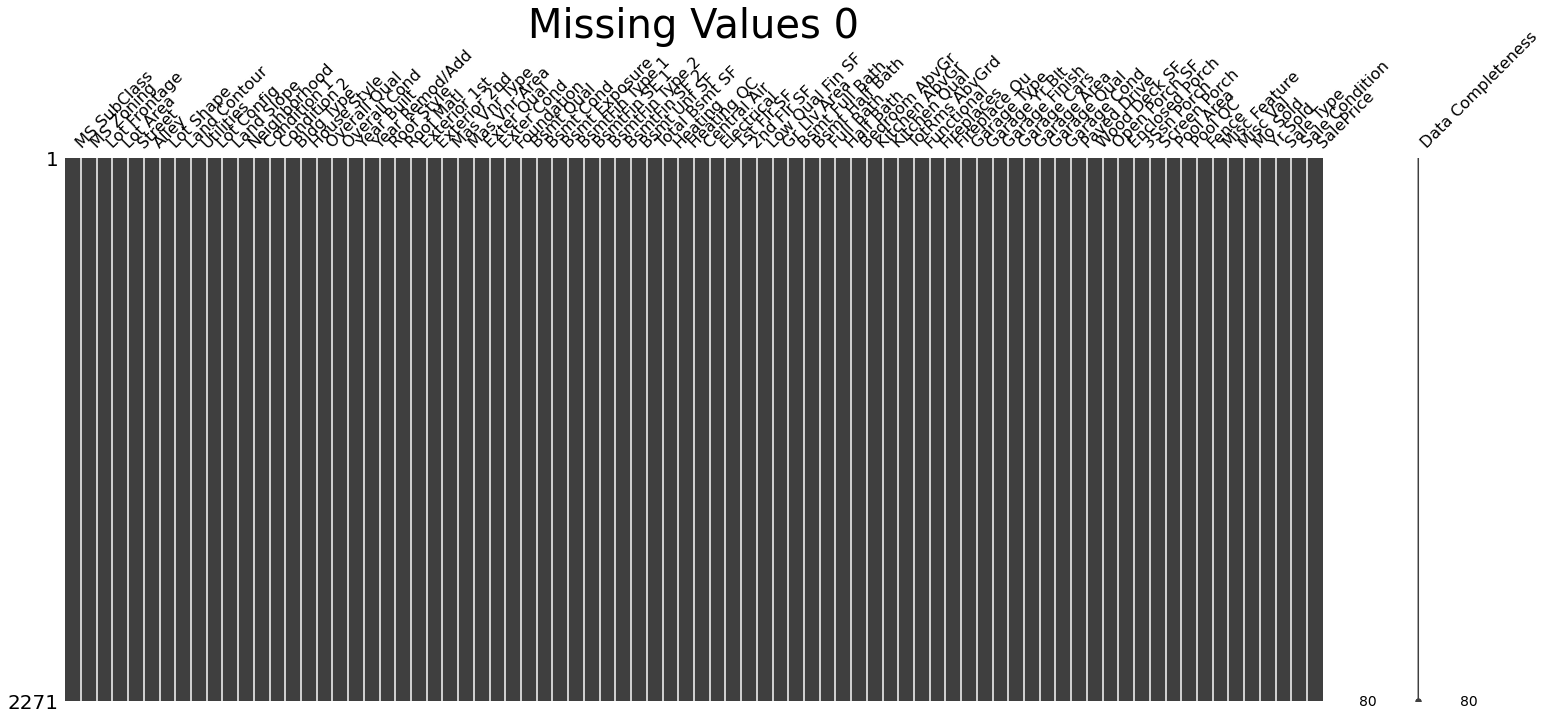

In [27]:
# Check missing values 
msno.matrix(train_df, labels=True)
plt.title("Missing Values {}".format(train_df.isna().sum().sum()), fontsize=40)
plt.show()

In [28]:
# Check normalize  Street in percentage ! 
train_df["Street"].value_counts(normalize=True)

Pave    0.996037
Grvl    0.003963
Name: Street, dtype: float64

In [29]:
""" Can be useful  """
train_df.interpolate() 

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,60,RL,68.0,8795,Pave,No alley access,3,Lvl,4,Inside,...,0,0,0,None,0,4,2009,WD,Normal,236000
1,20,RL,75.0,10170,Pave,No alley access,4,Lvl,4,Corner,...,0,0,0,None,0,6,2006,WD,Normal,155000
2,160,RM,21.0,2001,Pave,No alley access,4,Lvl,4,Inside,...,0,0,0,None,0,1,2007,WD,Normal,75000
3,20,RL,70.0,10552,Pave,No alley access,3,Lvl,4,Inside,...,0,0,0,None,0,4,2010,WD,Normal,165500
4,190,RM,60.0,10120,Pave,No alley access,3,Bnk,4,Inside,...,0,0,4,None,0,1,2007,WD,Normal,122000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,60,RL,62.0,8857,Pave,No alley access,3,Lvl,4,Inside,...,0,0,0,None,0,3,2007,New,Partial,171925
2426,20,RL,82.0,12464,Pave,No alley access,2,Low,4,Corner,...,0,0,5,None,0,11,2009,WD,Normal,152000
2427,60,RL,80.0,11584,Pave,No alley access,4,Lvl,4,Inside,...,0,0,0,None,0,11,2007,WD,Normal,197000
2428,80,RL,85.0,13400,Pave,No alley access,4,Lvl,4,Inside,...,0,0,3,None,0,6,2006,WD,Normal,159950


# Investigate how many unique numerical values each feature.

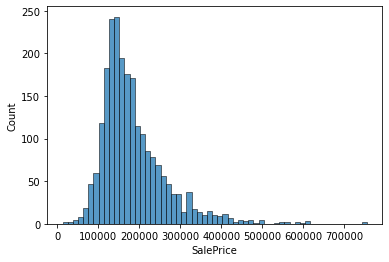

In [30]:
# Plot the count of unique values 
sns.histplot(x="SalePrice", data=train_df);

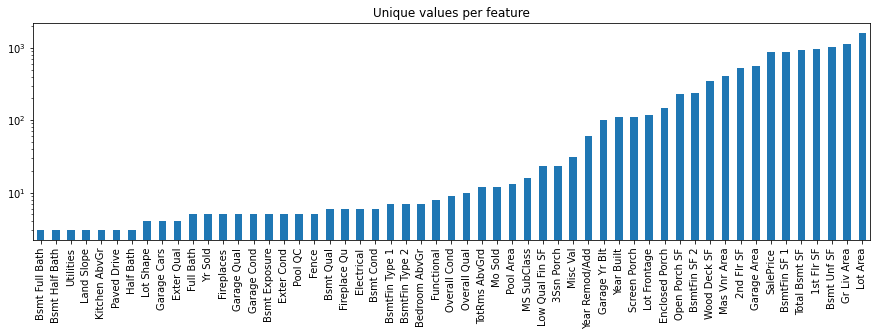

In [31]:
# Investigate how many unique numerical values each feature has. 
unique_values = train_df.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature")
plt.show()

In [32]:
""" # Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=4, nrows=10, figsize=(20, 50))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df_non_numerical[col].value_counts().plot.barh(title=col, ax=ax)
    
plt.tight_layout()
plt.show() """

' # Create figure object with 3 subplots\nfig, axes = plt.subplots(ncols=4, nrows=10, figsize=(20, 50))\n\n# Loop through features and put each subplot on a matplotlib axis object\nfor col, ax in zip(df_non_numerical.columns, axes.ravel()):\n\n    # Selects one single feature and counts number of occurrences per unique value\n    df_non_numerical[col].value_counts().plot.barh(title=col, ax=ax)\n    \nplt.tight_layout()\nplt.show() '

# To read 

Coding nominal variables for use in machine learning algorithms is often referred to as "encoding". There are several methods for encoding nominal variables, including:

1. One-hot encoding: This method creates a new binary column for each unique category in a nominal variable. For example, if a nominal variable has three categories (A, B, C), three new binary columns will be created. Each row will have a 1 in the column corresponding to its category and 0s in all other columns. This method works well when there are few categories in the nominal variable, but can result in a large number of new columns when there are many categories.

2. Ordinal encoding: This method assigns a numerical value to each category in a nominal variable based on its order or ranking. For example, if a nominal variable has three categories (A, B, C), they could be assigned the values 1, 2, 3 respectively. This method assumes that the categories have a natural ordering, and that the difference between the values is meaningful.

3. Dummy encoding: This method is similar to one-hot encoding, but avoids the issue of high-dimensional data by only creating k-1 columns for k categories. One column is dropped to avoid the issue of perfect multicollinearity, where two or more columns are highly correlated.

4. Target encoding: This method replaces the categories of a nominal variable with the mean of the target variable for each category. For example, if the target variable is a binary classification outcome, the mean of the target variable could be the probability of being in the positive class. This method requires careful tuning to avoid overfitting and should be used with cross-validation.

The appropriate encoding method will depend on the nature of the data and the requirements of the machine learning algorithm. For example, decision trees and random forests can handle categorical data without any encoding, while linear and logistic regression require encoding of nominal variables.





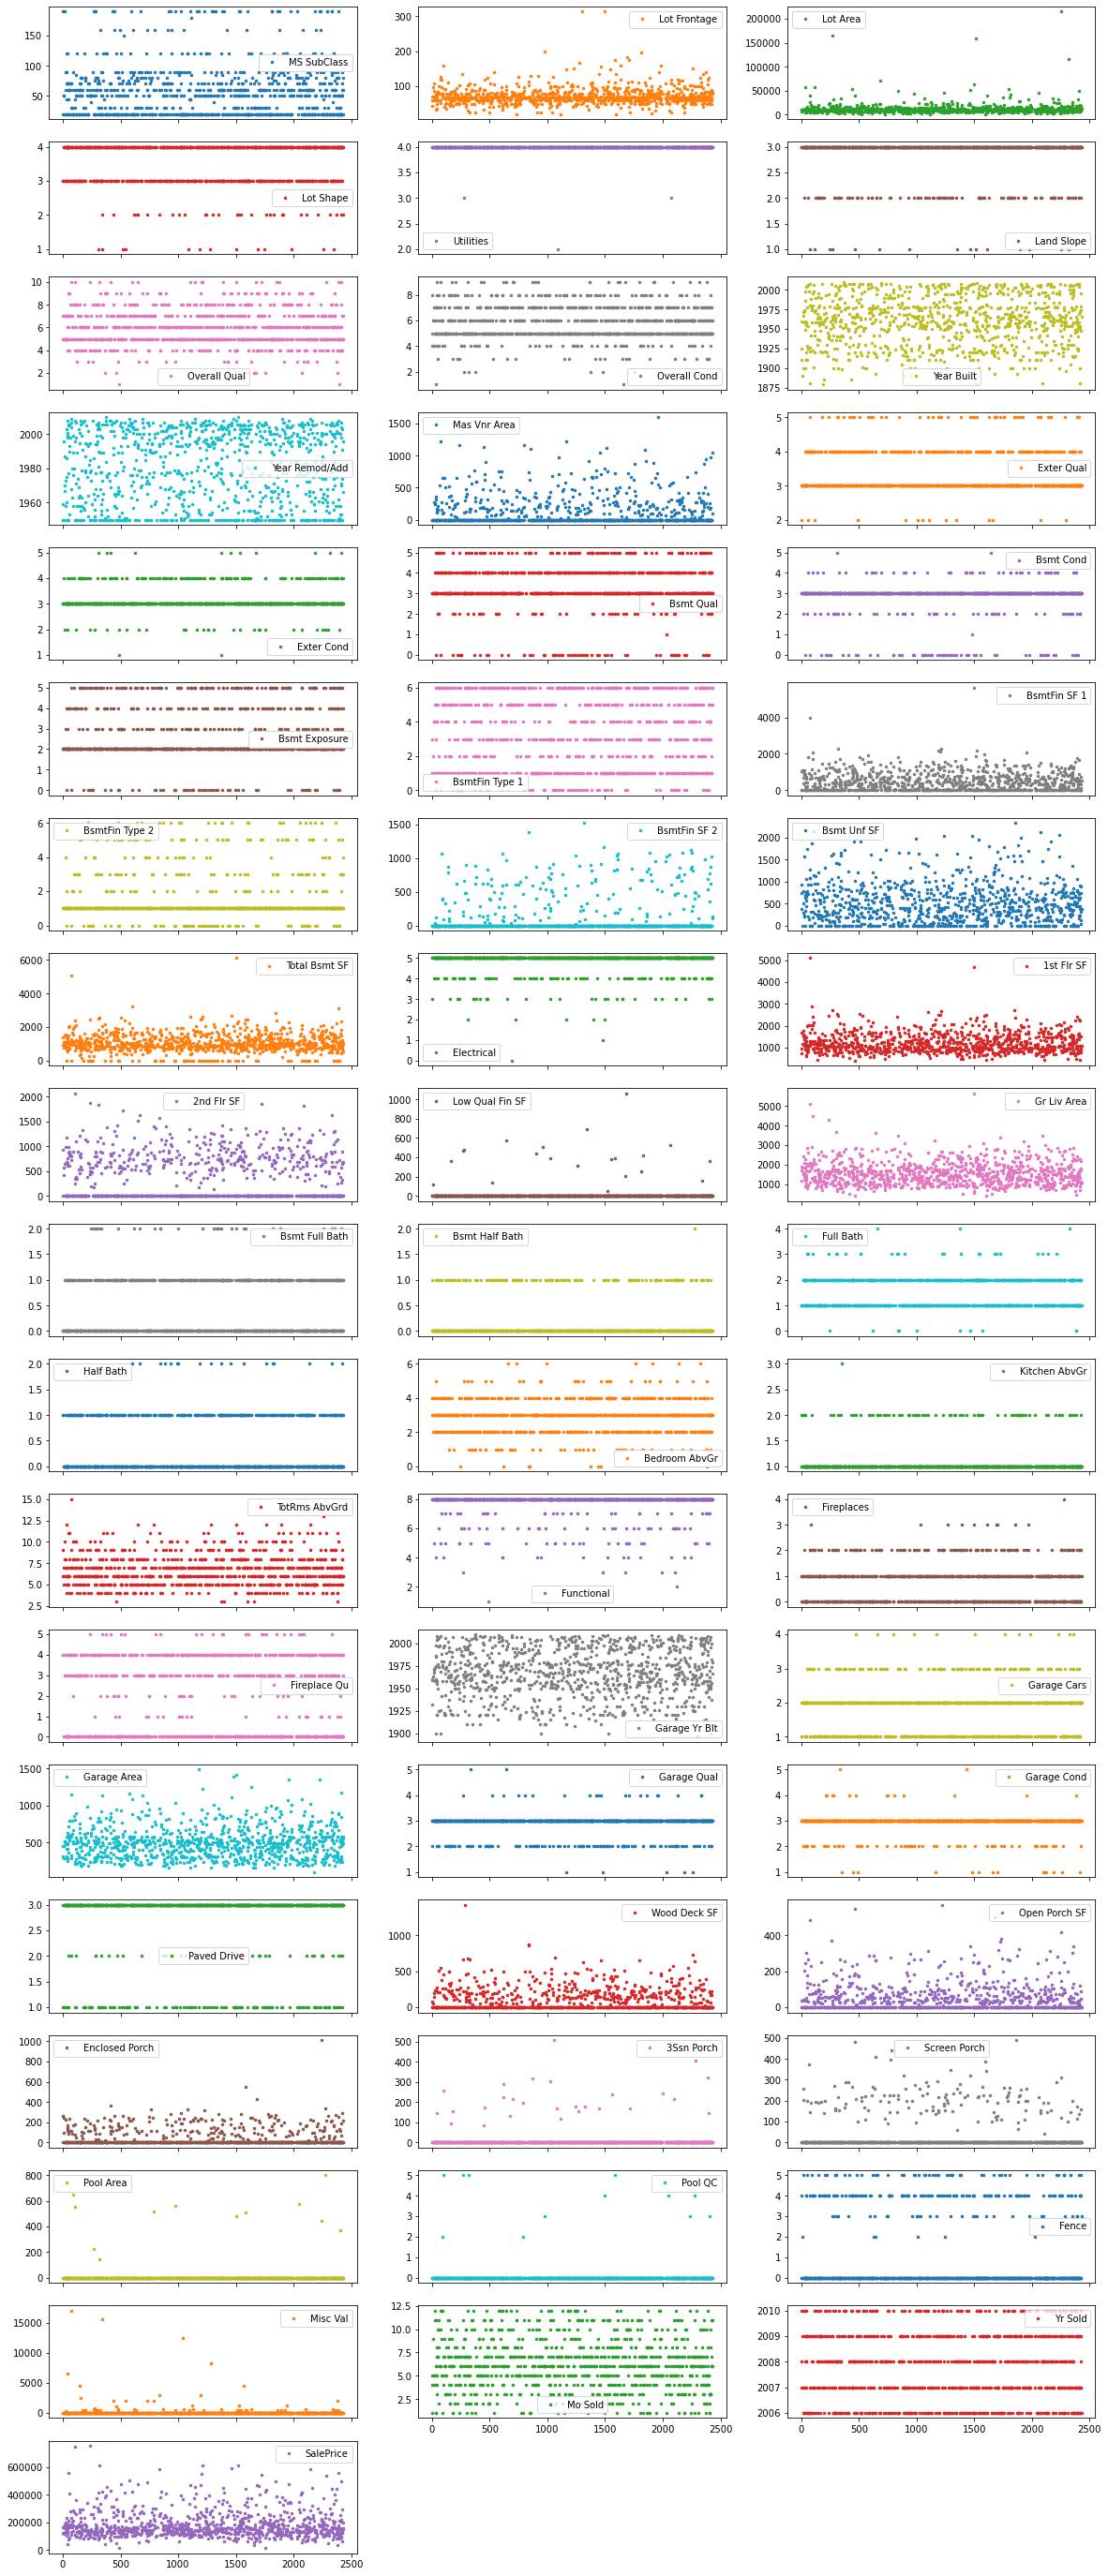

In [33]:
# Calculate the z-score of each data point
df_num = train_df.select_dtypes(include="number")

z_score = (df_num - df_num.mean()) / df_num.std()

# Define the threshold for the z-score
threshold = 3

# Identifly the data points taht lie outside the sepecified range
filtered_df = df_num[(np.abs(z_score) > threshold).any(axis=1)]

filtered_df.plot(
    subplots=True,
    marker=".",
    lw=0, 
    layout=(-1, 3),
    figsize=(20, 50),
    markersize=5,

);

Remove outlier according to the range set

In [34]:
# Set range 
range_values = {
    "Lot Frontage": [200, 320],
    "Lot Area": [60000, 220000],
    "Utilities" : [2, 3],
    "Mas Vnr Area" : [1500, 1600],
    "BsmtFin SF 1": [3000, 6000],
    "Enclosed Porch" : [600, 1200],
    "Bsmt Half Bath" : [1.70, 2],
    "Low Qual Fin SF" : [600, 1070],
    "Kitchen AbvGr" : [2.70, 3],
    "Wood Deck SF" : [800, 1500],
    "Enclosed Porch" : [350, 555],
    "Misc Val" : [6000, 16000],
    "3Ssn Porch" : [400, 600],
    "Enclosed Porch" : [1000, 1020],

} 

# Remove outlier according to the range set
for col in range_values:
    # Get range numbers
    num = range_values.get(col)
    # locate values that are in the range
    mask = train_df[col].between(num[0], num[1])
    # Drop values outide the sepecified range
    """ to remove!!!! """
    print(mask.loc[mask].shape) 
    train_df = train_df.drop(mask.loc[mask].index)
 

print("New train_df without outliers shape:", train_df.shape)


(3,)
(5,)
(3,)
(1,)
(1,)
(1,)
(1,)
(2,)
(1,)
(3,)
(4,)
(2,)
New train_df without outliers shape: (2244, 80)


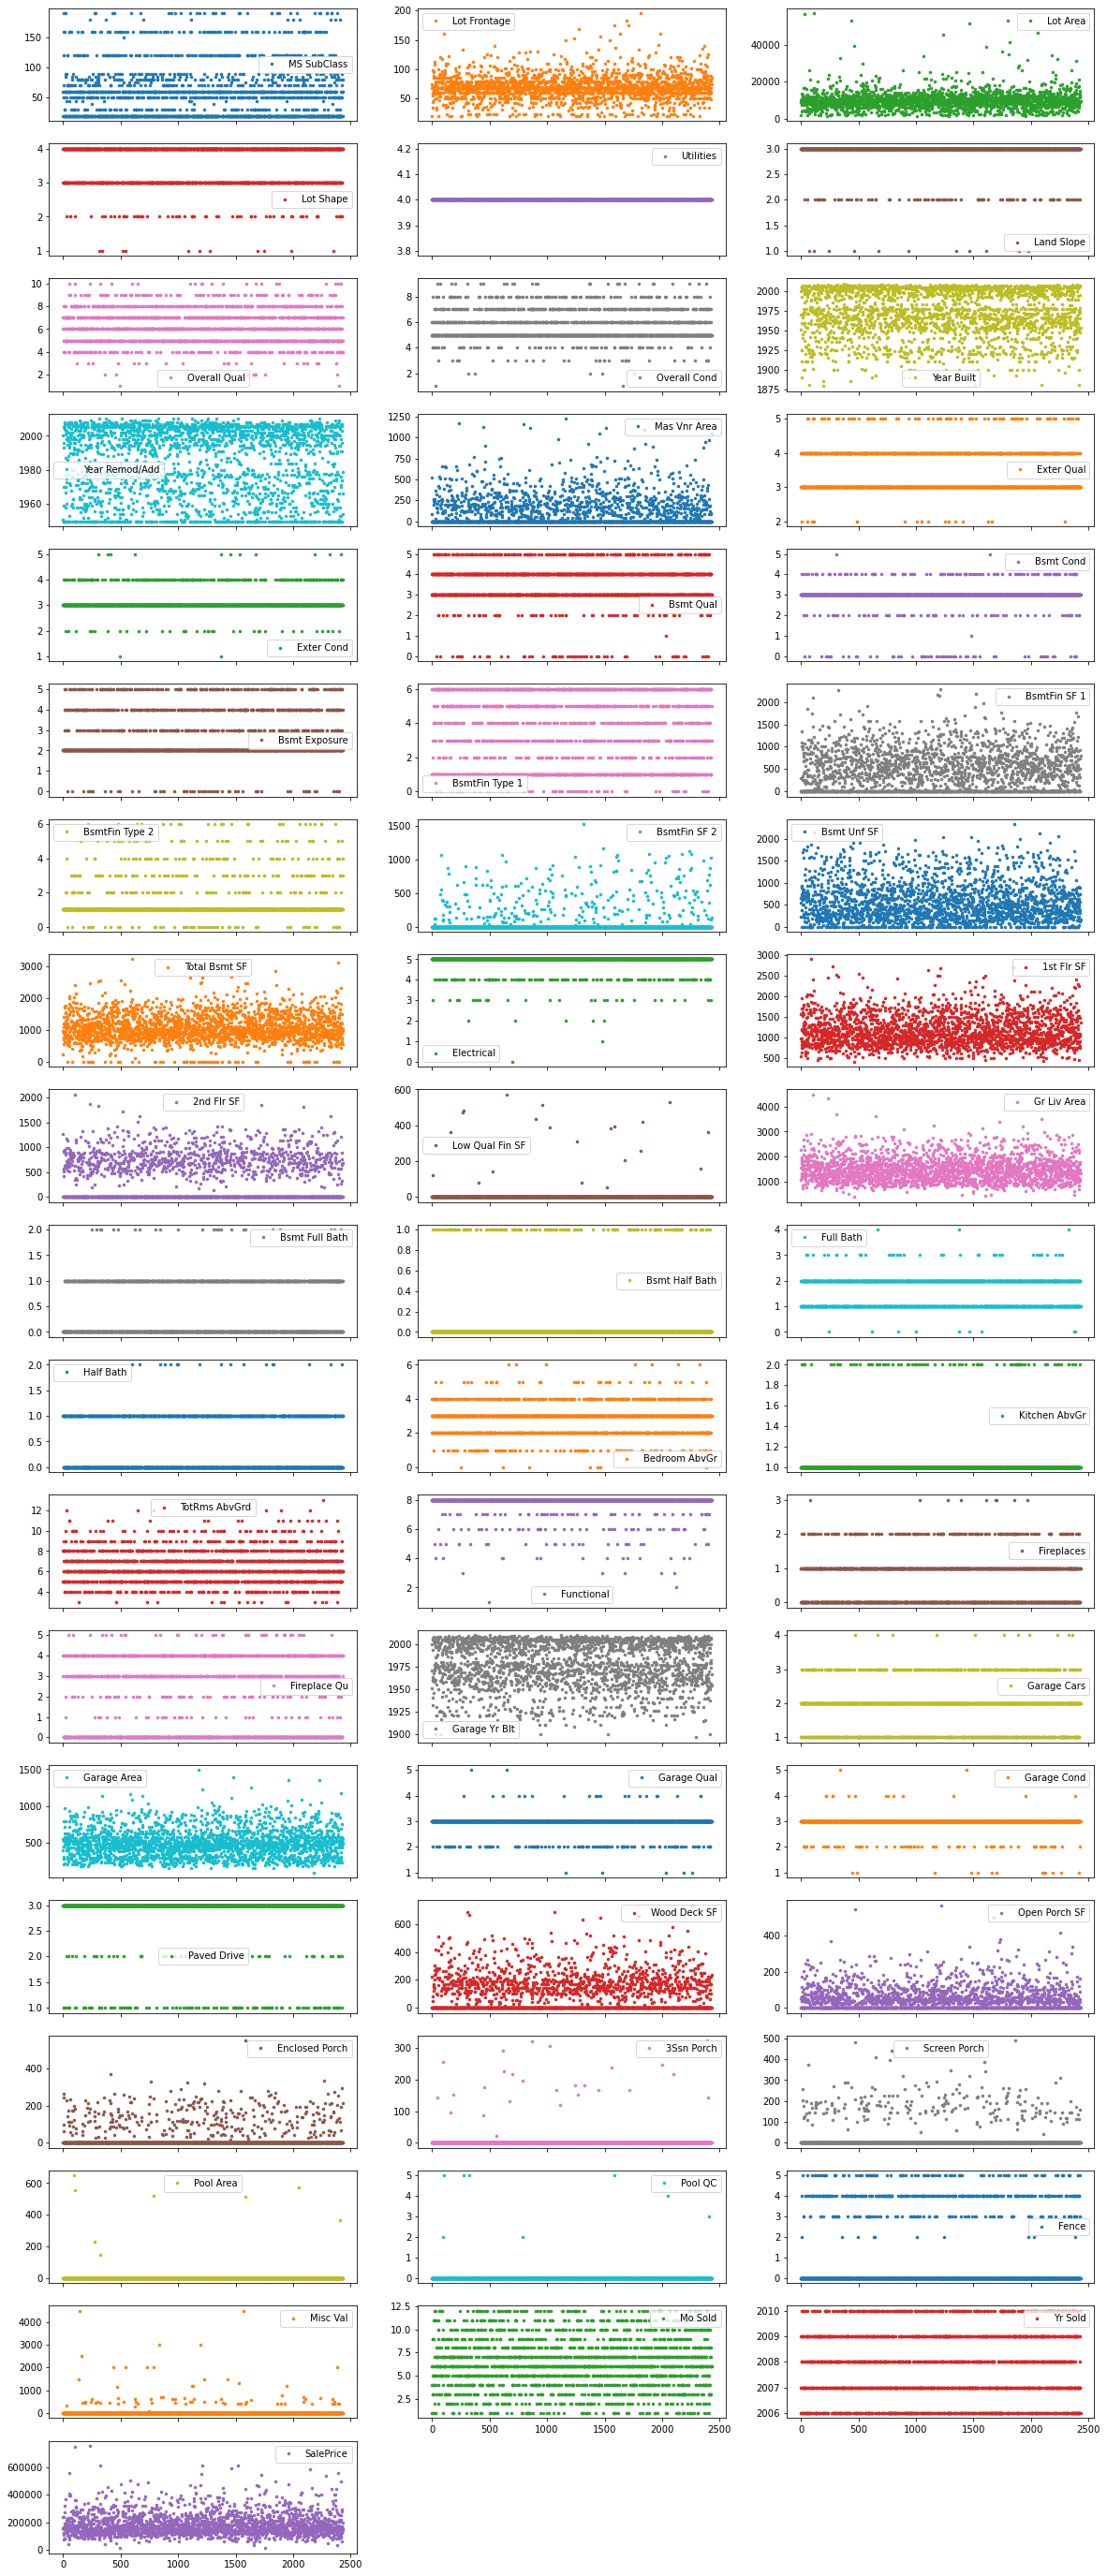

In [35]:
# Plot all numerical values to check outliers
train_df.plot(
    subplots=True,
    marker=".",
    lw=0, 
    layout=(-1, 3),
    figsize=(20, 50),
    markersize=5,

);


### Investigating the relative frequencies of the unique values in column ``Utilities``.

In [36]:
# Investigating Utilities 
train_df["Utilities"].value_counts(normalize=True)

4    1.0
Name: Utilities, dtype: float64

We see 100% of the columns contains the same value 4.

The ``Utilities`` column doesn't contain important information just if a house as Electricity, Gas, and Water etc.  So to save computation time I will remove the column.

In [37]:
# Drop Utilities
train_df = train_df.drop("Utilities", axis=1)

### Investagating the correlation pair columns

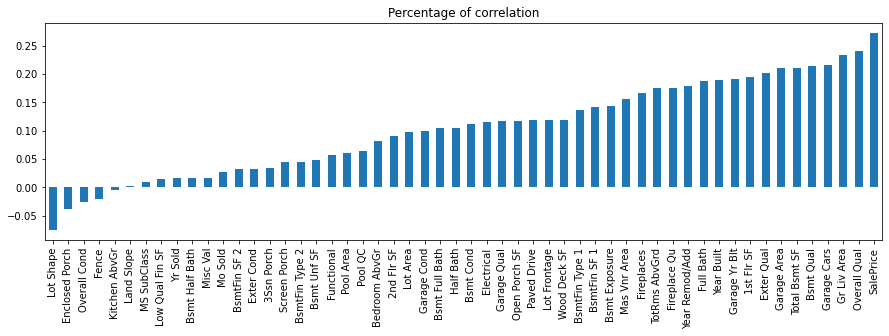

In [38]:
# Investagating the correlation pair columns
train_df.corr().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of correlation");

We see 2 collinear features by looking to the documentation I have fond features that have similarities with each other. 

By looking at the documentation
- We see that ``House Style`` and MS SubClass MS have similarities with each other.
- We see that ``BsmtFin SF 1`` and ``BsmtFin SF 2`` are already in  ``Total Bsmt SF`` I will remove the two other features.
- I have a look at ``"Street", "Alley", "Paved Drive" `` they have similarities with each other. To avoid confusion I will keep them.

In [39]:
# Drop House Style, BsmtFin SF 1 and BsmtFin SF 2 
train_df = train_df.drop(["House Style", "BsmtFin SF 1", "BsmtFin SF 2"], axis=1)

In [40]:
# Check "Street", "Alley", "Paved Drive 
# To avoid confusion I will keep them
train_df.loc[:, ["Street", "Alley", "Paved Drive"]]

,Street,Alley,Paved Drive
0,Pave,No alley access,3
1,Pave,No alley access,3
2,Pave,No alley access,3
3,Pave,No alley access,3
4,Pave,No alley access,1
...,...,...,...
2424,Pave,No alley access,3
2426,Pave,No alley access,3
2427,Pave,No alley access,3
2428,Pave,No alley access,3


Correcting inconsistencies in the variables by converting all the strings to lowercase using the ``"str.lower()`` method:

In [41]:
# Convert all string to lowercase
str_features = train_df.select_dtypes(exclude="number").columns

for col in str_features:
    train_df[col] = train_df[col].str.lower()

# Dispaly the change
train_df.select_dtypes(exclude="number").head()

,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,Roof Style,...,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Garage Type,Garage Finish,Misc Feature,Sale Type,Sale Condition
0,rl,pave,no alley access,lvl,inside,gilbert,norm,norm,1fam,gable,...,pconc,gasa,ex,y,gd,builtin,fin,none,wd,normal
1,rl,pave,no alley access,lvl,corner,names,norm,norm,1fam,hip,...,cblock,gasa,ta,y,gd,attchd,unf,none,wd,normal
2,rm,pave,no alley access,lvl,inside,meadowv,norm,norm,twnhs,gable,...,cblock,gasa,fa,y,ta,attchd,unf,none,wd,normal
3,rl,pave,no alley access,lvl,inside,names,norm,norm,1fam,hip,...,cblock,gasa,gd,y,gd,attchd,rfn,none,wd,normal
4,rm,pave,no alley access,bnk,inside,oldtown,feedr,norm,2fmcon,hip,...,cblock,gasa,ta,n,ta,detchd,unf,none,wd,normal


### Feature engineering
Your analysis should also include feature engineering. Here are a few ideas

- Create indicator variables ex. year of construction is older than some threshold
- Transformations ex. log-transforms, polynomials


Adding total counts of feature to compress the information and removeing the original features.

In [42]:
# Sum up 1st Flr SF and 2nd Flr SF to "total Flr SF"
train_df["total Flr SF"] = train_df.loc[:, ["1st Flr SF", "2nd Flr SF"]].sum(axis=1) 
train_df = train_df.drop(["1st Flr SF", "2nd Flr SF"], axis=1)

Create indicator variables for year of construction if values are above the threshold we set 1 and 0 if lower 

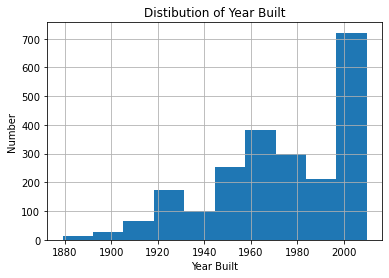

In [43]:
# Explore the distibution of Year Built
train_df["Year Built"].hist()
plt.title("Distibution of Year Built")
plt.xlabel("Year Built")
plt.ylabel("Number")
plt.show()


I will take the median as threshodl

In [44]:
# Set the threshold year
threshold_year = train_df["Year Built"].median()

# Create a new column 'OlderThanThreshold' based on the condition that 'YearBuilt' is older than the threshold year
train_df['Year Built before 1975'] = (train_df['Year Built'] < threshold_year).astype(int)

# Drop 'Year Built'
train_df = train_df.drop('Year Built', axis=1)

# Display the new column 
train_df['Year Built before 1975']

0       0
1       1
2       1
3       1
4       1
       ..
2424    0
2426    0
2427    0
2428    1
2429    1
Name: Year Built before 1975, Length: 2244, dtype: int32

The above code creates a new column ``"Year Built before 1975"`` in the DataFrame, with the values 0 or 1, depending on whether the year of construction in the ``"Year Built"`` column is older or not than the threshold. The ``astype(int)`` method is used to convert the values to integers.

Doing the same for ``Garage Yr Blt`` taking the median and setting all values above this threshold to 1 and 0 if lower

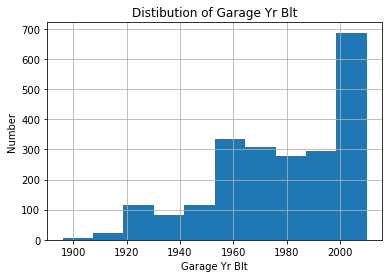

In [45]:
train_df["Garage Yr Blt"].hist()
plt.title("Distibution of Garage Yr Blt")
plt.xlabel("Garage Yr Blt")
plt.ylabel("Number")
plt.show()

In [46]:
# Set the threshold year
threshold_year_garage = train_df["Garage Yr Blt"].median()

# Create a new column 'OlderThanThreshold' based on the condition that 'YearBuilt' is older than the threshold year
train_df['Garage Yr Blt before 1978'] = (train_df['Garage Yr Blt'] < threshold_year).astype(int)

# Drop 'Year Built'
train_df = train_df.drop('Garage Yr Blt', axis=1)

# Display the new column 
train_df['Garage Yr Blt before 1978']

0       0
1       1
2       1
3       1
4       1
       ..
2424    0
2426    0
2427    0
2428    1
2429    1
Name: Garage Yr Blt before 1978, Length: 2244, dtype: int32

# Plot in a histogram each numerical feature to see the distribution pattern in a separate subplot

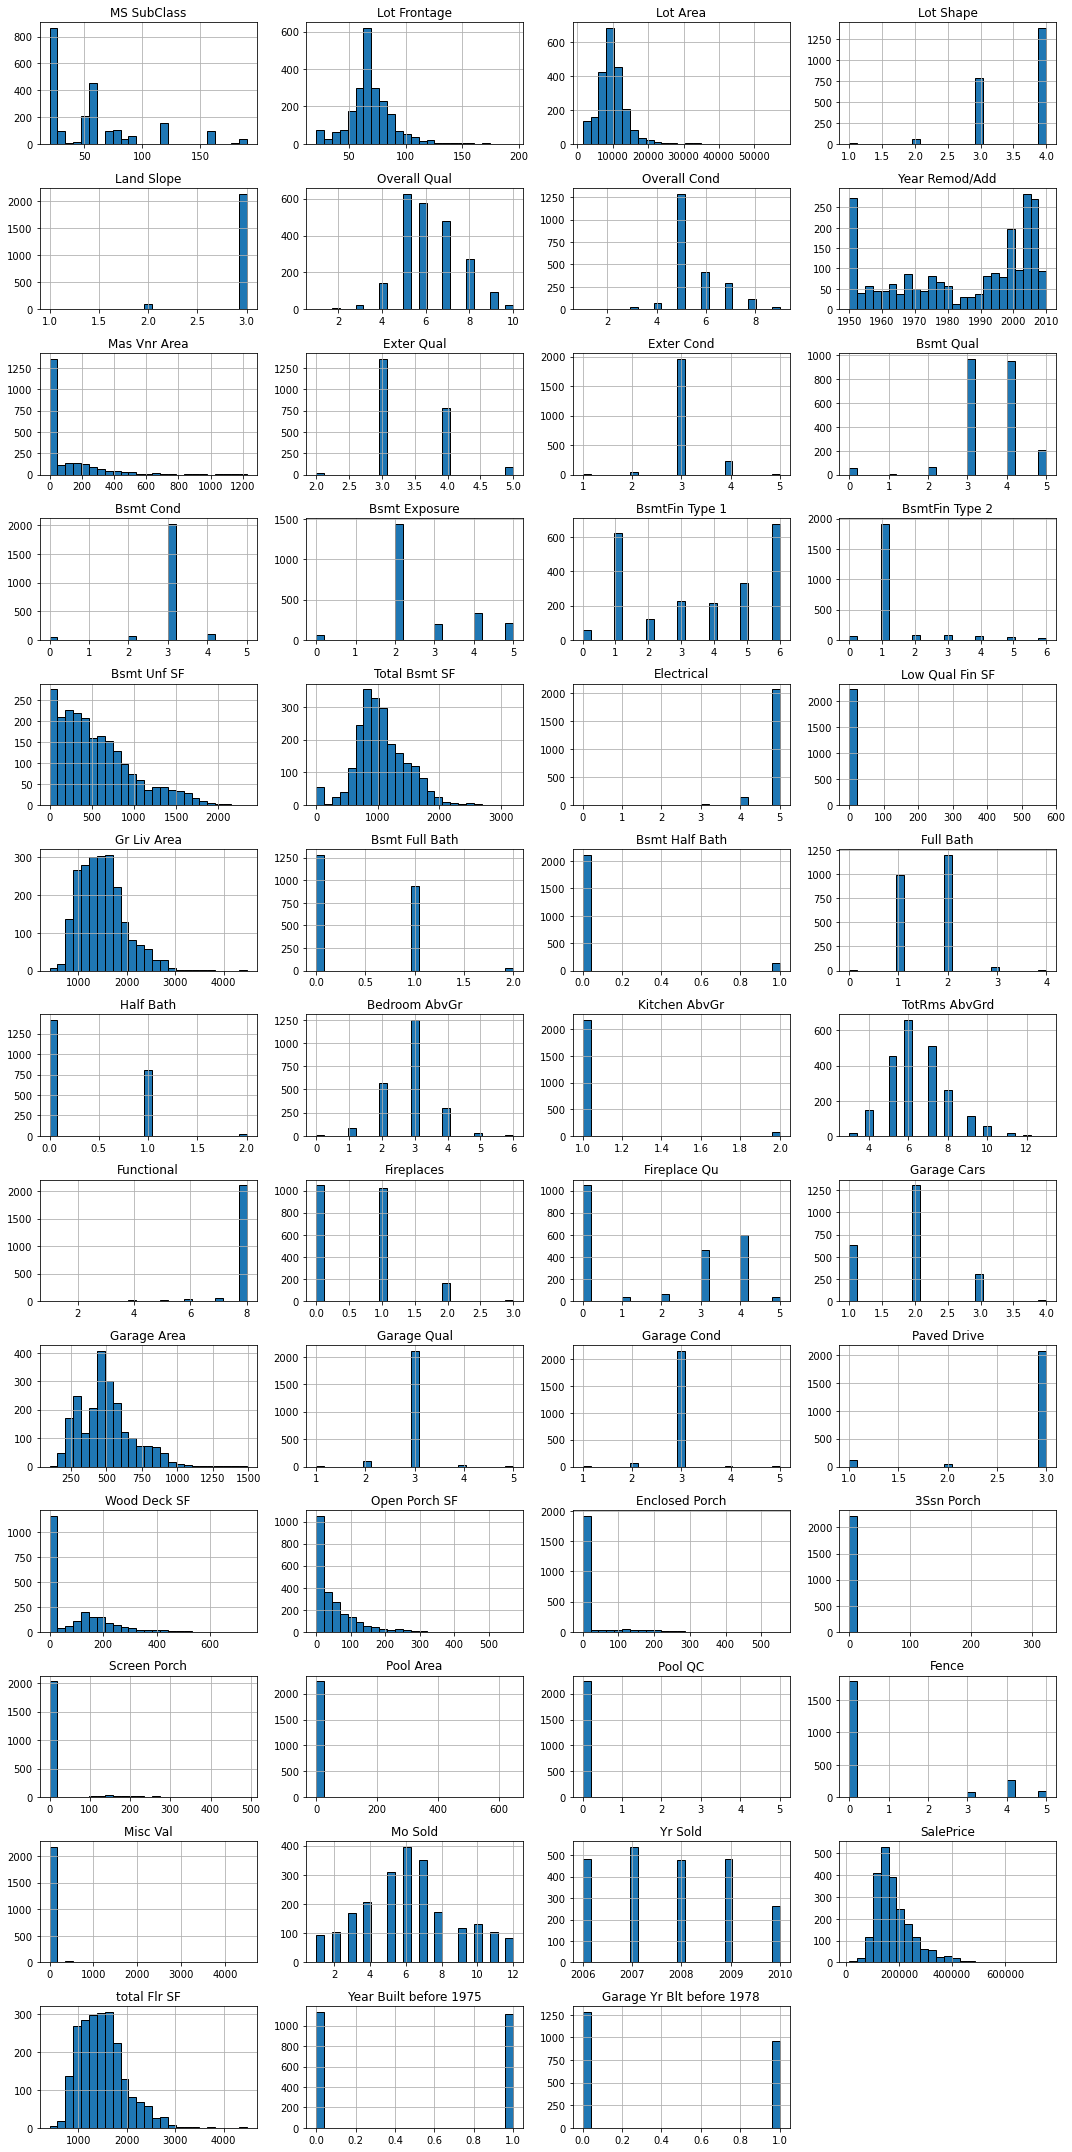

In [47]:
# Plots the histogram for each numerical feature in a separate subplot
train_df.hist(bins=25, figsize=(15, 30), layout=(-1, 4), edgecolor="black")
plt.tight_layout()

The data has many extreme values or outliers, using ``np.log1p`` to make the distribution more symmetric and reduce the impact of these extreme values.

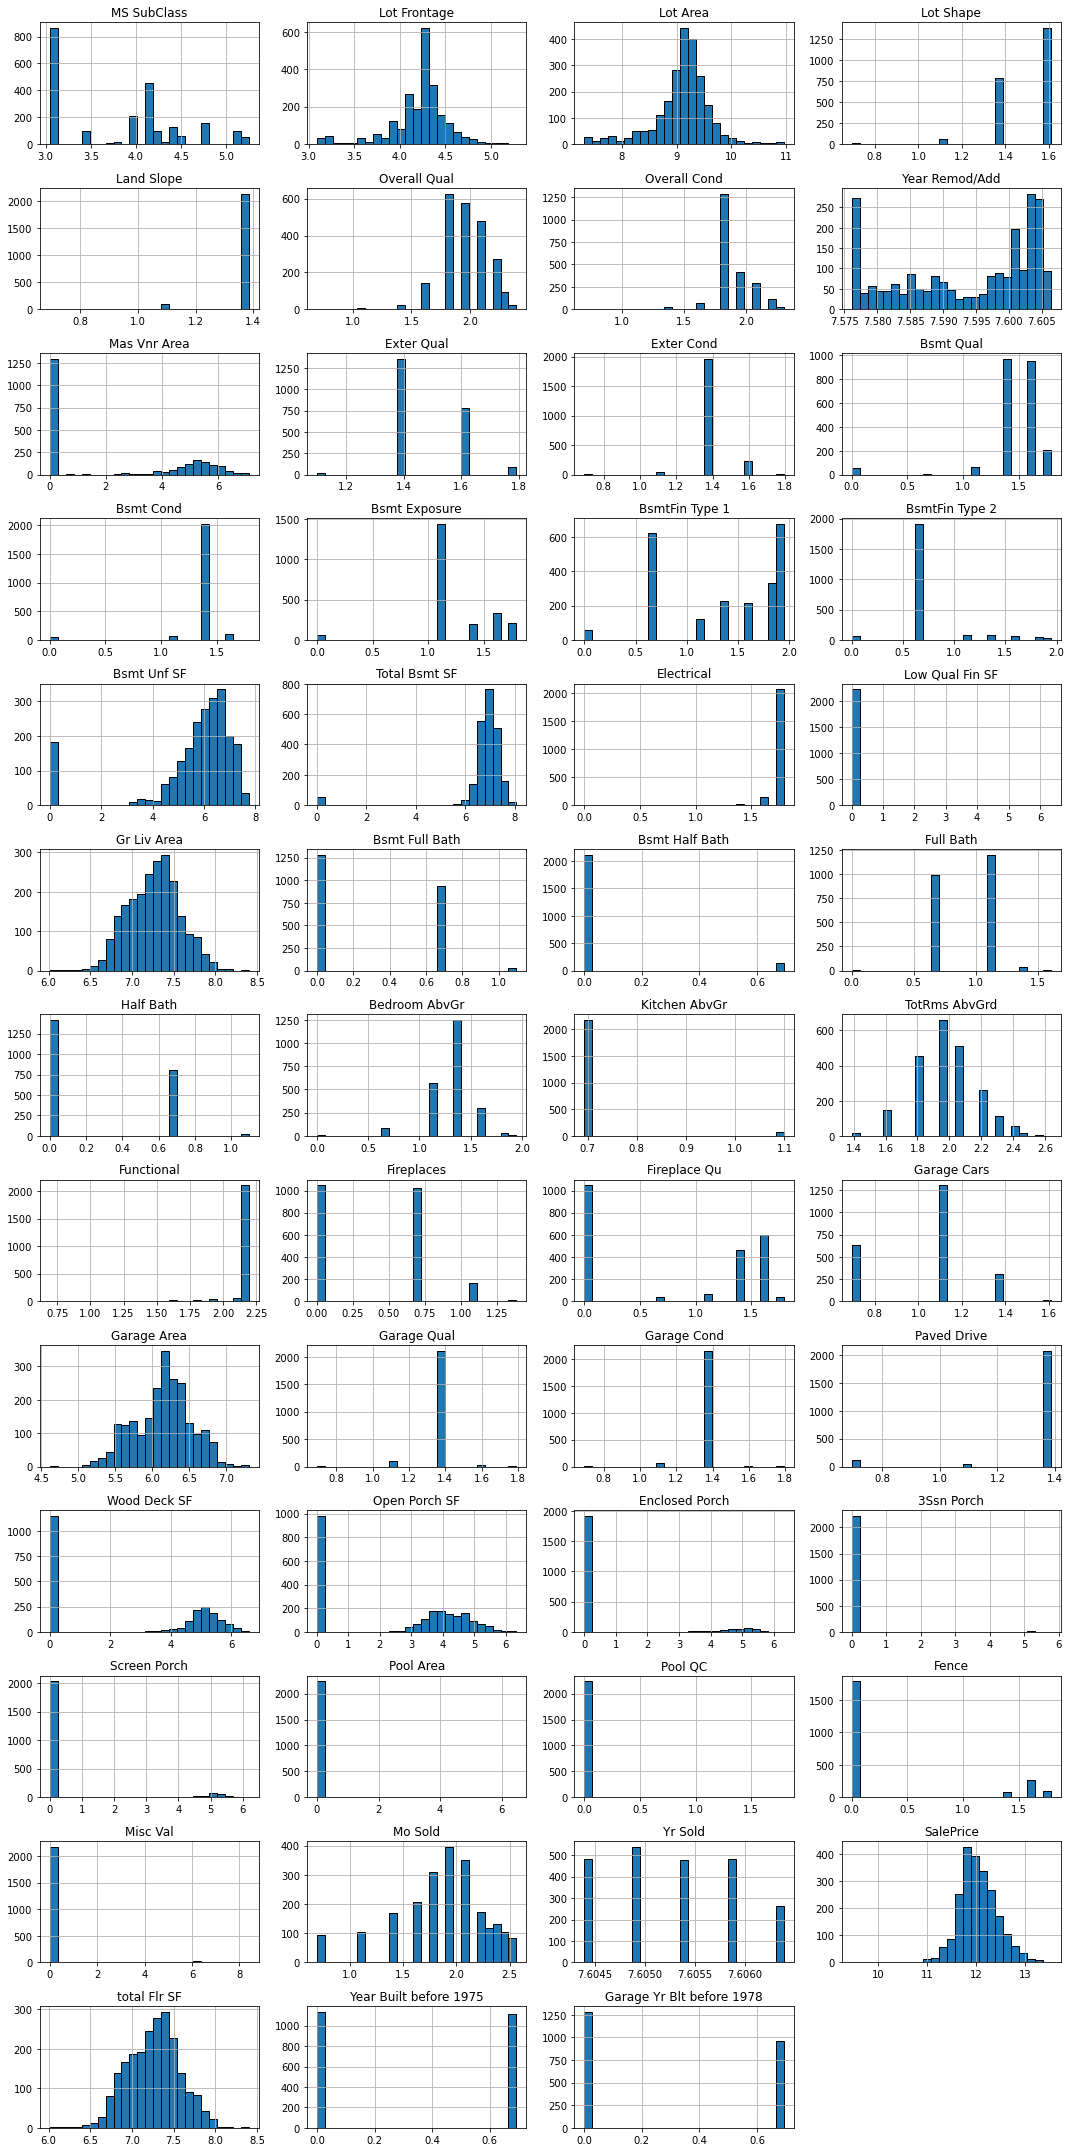

In [48]:
sqrt_df = train_df.select_dtypes(include="number").applymap(np.log1p)
sqrt_df.hist(bins=25, figsize=(15, 30), layout=(-1, 4), edgecolor="black")
plt.tight_layout()

We See a normal distribution pattern starting to appear
### Applying ``np.log1p`` to all numerical data and save it

In [49]:
# Applaying ``np.sqrt`` to all numercal data
df_num = train_df.select_dtypes(include="number").columns
train_df[df_num] = train_df[df_num].applymap(np.log1p)

# Feature encoding
Your analysis should include the necessary feature encoding steps. The documentation.txt file labels each variable with its type. For categorical ones, it uses the ordinal and nominal classification.

- Ordinal variables - you can order the categories
- Nominal variables - no possible ordering of the categories

The encoding depends on the type of variable and its meaning. For instance, the kitchen quality variable is on a scale from excellent to poor. Hence, it’s an ordinal variable, and you can choose to apply one-hot encoding or define a numerical scale ex. excellent corresponds to 5 and poor to 1. In any case, justify your choices!

I`ve alwardy encodede all the Ordinal columnes for the other columns I will just encode them using the ``pd.get_dummies()`` method.

# Checking collinear features

In [50]:
features = train_df.select_dtypes(include="number").columns

# Create input matrix with the additional column of ones
X = train_df[features].values
X1 = np.c_[np.ones(X.shape[0]), X]
# Compute rank and condition number
M = X1.shape[1]  # Number of columns
rank = np.linalg.matrix_rank(X1)
cond = np.linalg.cond(X1)
print("Columns {} rank {} collinear {}".format(M, rank, M - rank))
print("Condition number:", cond)

Columns 52 rank 52 collinear 0
Condition number: 313049.4551591098


The Condition number is a bit large but I will continue.

In [51]:
# One-hot encode
df_dummies = pd.get_dummies(train_df, drop_first=True)




Suggestion:
---

- Creating a new binary or categorical variable that indicates the presence or absence of some characteristic. For example, creating a binary indicator for houses that are older than a certain age.

- Transforming the original features to create new, potentially more informative features. Common transformations include log-transforms, polynomials, square roots, and reciprocals. These can help improve the linearity of the relationship between the features and the target variable, making it easier for a model to learn the relationship.

- Grouping continuous variables into a smaller number of categories. This can help reduce the impact of outliers and improve the interpretability of the model.

- Creating new features that are the product or sum of two or more original features. Interactions can capture non-linear relationships between features and target variables, which might be missed by a linear model.

Splitting data
---
You should split the data into training and validation sets (e.g. 60-40 split). You will use the training set for fitting the models and the validation set for evaluating the models and tuning hyperparameters.

In [52]:
X = df_dummies.drop("SalePrice", axis=1)
y = df_dummies.SalePrice

# Spliting data
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.4, random_state=0)

Model fitting
---
Your analysis should include an appropriate baseline and evaluate three different models ranging in complexity

- A baseline that entails no modeling, and supposedly should be beaten by the three models
- A simple model with two variables (three with the target variable)
An intermediate model (between 10 and 20 variables)
- A complex model with all variables


The number of variables is only given as an indication, it’s not a strict range. Also, it corresponds to the variables count before one-hot encoding. For the simple and intermediate models, you can choose the variables. You are free to choose your preferred approach for this variable selection step, but you should include a short comment to explain your choice.

Regularization
---
Your analysis should include regularization for the complex model.

Briefly explain the objective of regularization, and how it will make the complex model different from other models
Tune regularization strength with grid search
Plot the training and validation curves
Discuss what you observe in the plot, e.g. potential overfitting

The objective of regularization is to prevent overfitting in a statistical model by adding a penalty term to the loss function. I'm using the L2 penalty in Ridge regression 

# Fitting the different regression

In [53]:
""" to remove """
""" import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) """

' import warnings\nwarnings.filterwarnings("ignore", category=RuntimeWarning) '

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Setup each regression
simple_lr =  Pipeline([("v1", SelectKBest(score_func=f_regression, k=2)), ("lr", LinearRegression())])
intermediate_lr =  Pipeline([("v2", SelectKBest(score_func=f_regression, k=20)), ("lr2", LinearRegression())])
ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1))])

# Fit 
simple_lr.fit(X_tr, y_tr)
intermediate_lr.fit(X_tr, y_tr)
ridge.fit(X_tr, y_tr)

# Save simple and intermediate results
mea_simple = MAE(np.expm1(y_val), np.expm1(simple_lr.predict(X_val)))
mea_interdiate = MAE(np.expm1(y_val), np.expm1(intermediate_lr.predict(X_val)))

# Display the results
print("MAE for simple linear regression: {:.3f}$".format(mea_simple))
print("MAE for intermediate linear regression: {:.3f}$".format(mea_interdiate))
print("MAE for all features with ridge regression: {:.3f}$".format(MAE(np.expm1(y_val), np.expm1(ridge.predict(X_val)))))

MAE for simple linear regression: 25066.465$
MAE for intermediate linear regression: 20105.759$
MAE for all features with ridge regression: 14315.228$


c:\Users\louis\anaconda3\envs\adsml\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
c:\Users\louis\anaconda3\envs\adsml\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


- Tune regularization strength with grid search

Note: the MAE results are real values but doing the predition on the square roots

In [55]:
from sklearn.metrics import mean_squared_error as MSE
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.sqrt(np.logspace(0, 8, num=20)):
    # Fit the pipeline
    ridge.set_params(ridge__alpha=alpha)
    ridge.fit(X_tr, y_tr)

    # Save model and its performance on the train/test sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mae": MAE(np.expm1(y_tr), np.expm1(ridge.predict(X_tr))),
            "val_mae": MAE(np.expm1(y_val), np.expm1(ridge.predict(X_val))),
            "val_mse": MSE(np.expm1(y_val), np.expm1(ridge.predict(X_val))),
        }
    )

# Convert results to DataFrame
df_results = pd.DataFrame(gs_results)
# Group by alpha 
gb_alpha = df_results.groupby("alpha")
# Compute the mean of validation mse
val_mean = gb_alpha.val_mse.mean()
# Find the best alpha
best_alpha = val_mean.idxmin()

# Print best alpha
print("Best alpha: {:.1e}".format(best_alpha))
print("Best result: {:.1f}$".format(df_results["val_mae"].min()))

Best alpha: 1.1e+01
Best result: 14214.8$


- Plot the training and validation curves


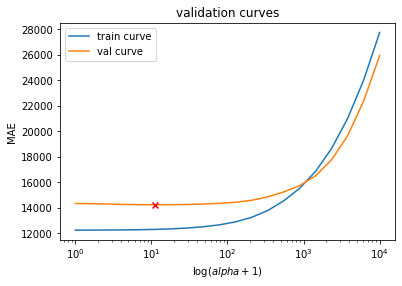

In [57]:
# Plot the validation curves 
plt.semilogx(df_results["alpha"], df_results["train_mae"], label="train curve")
plt.semilogx(df_results["alpha"], df_results["val_mae"], label="val curve")
plt.scatter(best_alpha, df_results["val_mae"].min(), marker="x", c="red", zorder=10)
plt.title("validation curves")
plt.xlabel("$\log(alpha + 1)$")
plt.ylabel("MAE")
plt.legend()
plt.show()

- Discuss what you observe in the plot, e.g. potential overfitting

We see a good curve and stable until we get to the best alpha after this point the model start underfitting as the alpha values increase. 

### Update alpha parameter for ridge regression
Change alpha paramater to compute the best  ridge model and compute the new predition


In [58]:
# Update alpha parameter for ridge regression
ridge.set_params(ridge__alpha=7)
ridge.fit(X_tr, y_tr)
# Save pedition
mea_ridge = MAE(np.expm1(y_val), np.expm1(ridge.predict(X_val)))
print("Ridge regression with best alpha: {:.3f}$".format(mea_ridge))

Ridge regression with best alpha: 14224.267$


Computing the $R^2$ coefficient to measure of how well-observed outcomes are replicated by the model

In [59]:
from sklearn.metrics import r2_score
 
# Compute R^2 coefficients
print("r2_score: {:.3f}".format(r2_score(np.expm1(y_val), np.expm1(ridge.predict(X_val)))))

r2_score: 0.924


The coefficient of determination $R^2$ of 92 % is a good score 

# Final comparion

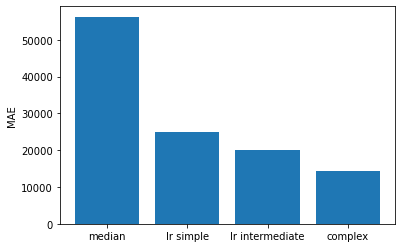

In [60]:
# Compute baseline
baseline = np.mean(np.abs(np.expm1(y_tr) - np.expm1(np.median(y_val))))

# Plot
mea_values = [baseline, mea_simple, mea_interdiate, mea_ridge]
titles = ["median", "lr simple", "lr intermediate", "complex"]

plt.bar(titles, mea_values)
plt.ylabel("MAE")
plt.show()


## Predicting on test data
Now that you have your three models ready, let’s go to the 500 new houses that are unseen by your models. They make your test set. Get the attributes of these houses from house-prices-test.csv and predict their prices using each model and save them in a .csv file.

- Predictions from your simple model - ``predictions-simple-model.csv``
- Predictions from your intermediate model - ``predictions-intermediate-model.csv``
- Predictions from your complex model - ``predictions-complex-model.csv``

Your .csv files must contain 500 rows and 2 columns: the house PID and the predicted price as SalePrice

In [61]:
df_test = pd.read_csv("house-prices-test.csv")
df_test.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,2217,909279080,50,RL,NaN,11275,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1,837,907126050,20,RL,65.0,9757,Pave,NaN,Reg,Low,...,92,0,NaN,NaN,NaN,0,10,2009,WD,Normal
2,2397,528144030,60,RL,86.0,11065,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,10,2006,New,Partial
3,1963,535452060,20,RL,70.0,7000,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnWw,NaN,0,4,2007,WD,Family
4,306,911202100,50,C (all),66.0,8712,Pave,Pave,Reg,HLS,...,0,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml


cleaning the data in the same way it was cleaned during the training and validation phases.

In [62]:
""" to do """

' to do '

In [63]:
df_test.isna().sum().sum()

2327